In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

warnings.filterwarnings('ignore')

# Small updates to Figure 2 plots

offset    18
Name: 202001261800, dtype: int64 9.116


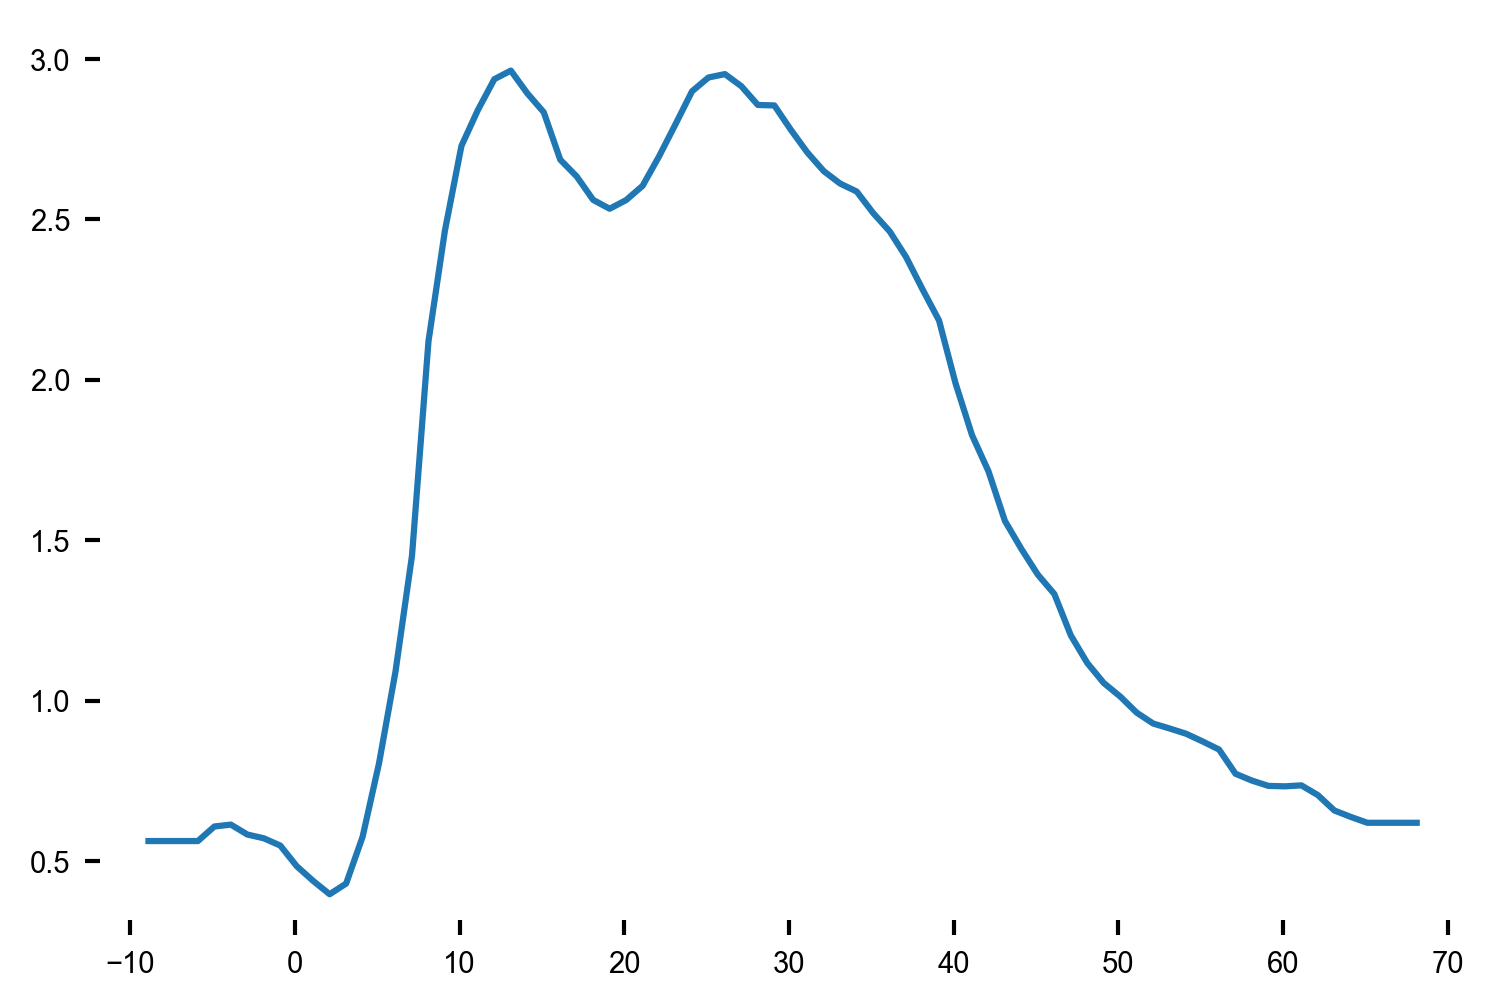

In [45]:
from PIL import Image
# Load e-cadherin embryo 
loaddir = '../Public/WT/ECad-GFP/202001261800'

morph = pd.read_csv(f'{loaddir}/../morphodynamic_offsets.csv', index_col='embryoID')

raw = Image.open(f'{loaddir}/MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif')
#raw = Image.open('eCad_Figure2c\'\'\'.tif')
proc = np.load(f'{loaddir}/raw2D.npy')
time = np.arange(proc.shape[0]).astype(float)
time += np.loadtxt(f'{loaddir}/timematch_linearOffset_curlSign.txt', delimiter=',')[0, 0]
time -= morph.loc[202001261800, 'offset']
print(morph.loc[202001261800], np.loadtxt(f'{loaddir}/timematch_linearOffset_curlSign.txt', delimiter=',')[0, 0])

vel = np.load(f'{loaddir}/velocity2D.npy')
plt.plot(time, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)))

0 (236, 200) (2050, 1738)
214 2005 476.00040276179516 162.21059189331132
29 (236, 200) (2050, 1738)
179 2577 381.53367649948075 150.30776637187498


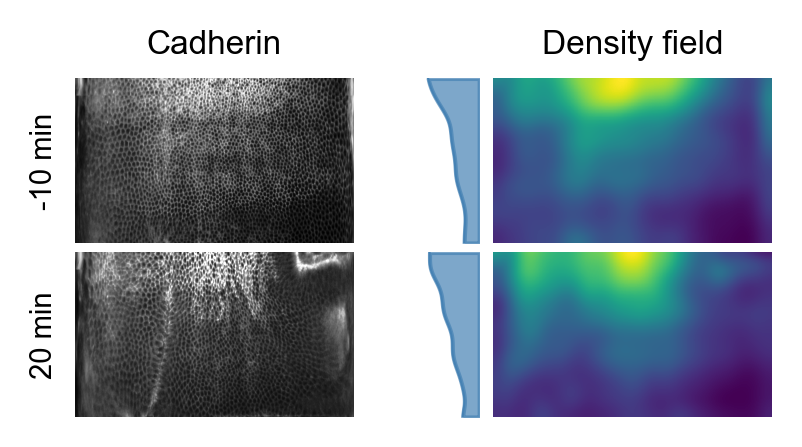

In [38]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from utils.plot_utils import color_2D, plot_tensor2D
from scipy.ndimage import gaussian_filter

plt.style.use('Figure2/Figure2.mplstyle')
plt.rcParams['axes.linewidth'] = 0.0

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()
    

color='steelblue'
t = [-10, 20]

fig, ax = plt.subplots(2, 2, figsize=(3, 1.5))
extent = [0, 452, 0, 533]

cad_cuts = []
for i, tt in enumerate(t):
    idx = np.argmin(np.abs(time - tt))
    proc_t = proc[idx]
    #raw.seek(idx)
    raw.seek(i) #Using sebastians improved pullback
    raw_t = np.asarray(raw)
    
    print(idx, proc_t.shape, raw_t.shape)
    print(raw_t.min(), raw_t.max(), raw_t.mean(), raw_t.std())
    color_2D(ax[i, 0], raw_t, 
             vmin=np.mean(raw_t) - 1.5 * np.std(raw_t), vmax=np.mean(raw_t) + 5 * raw_t.std(),
             extent=extent, cmap='Greys_r')
    
    proc_t = gaussian_filter(proc_t, sigma=7)
    color_2D(ax[i, 1], proc_t, extent=extent)
    cad_cuts.append(get_DV_cut(proc_t, 100, 180))
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
cad_cuts = np.stack(cad_cuts)
for i in range(2):
    plot_cut(ax[i, 1], cad_cuts[i], 0.4*cad_cuts.max(), cad_cuts.max(), color=color)
    
ax[0, 0].set_title('Cadherin')
ax[0, 1].set_title('Density field')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

#plt.savefig('Figure2/cadherin_replot.svg')

(0.0, 20.0)

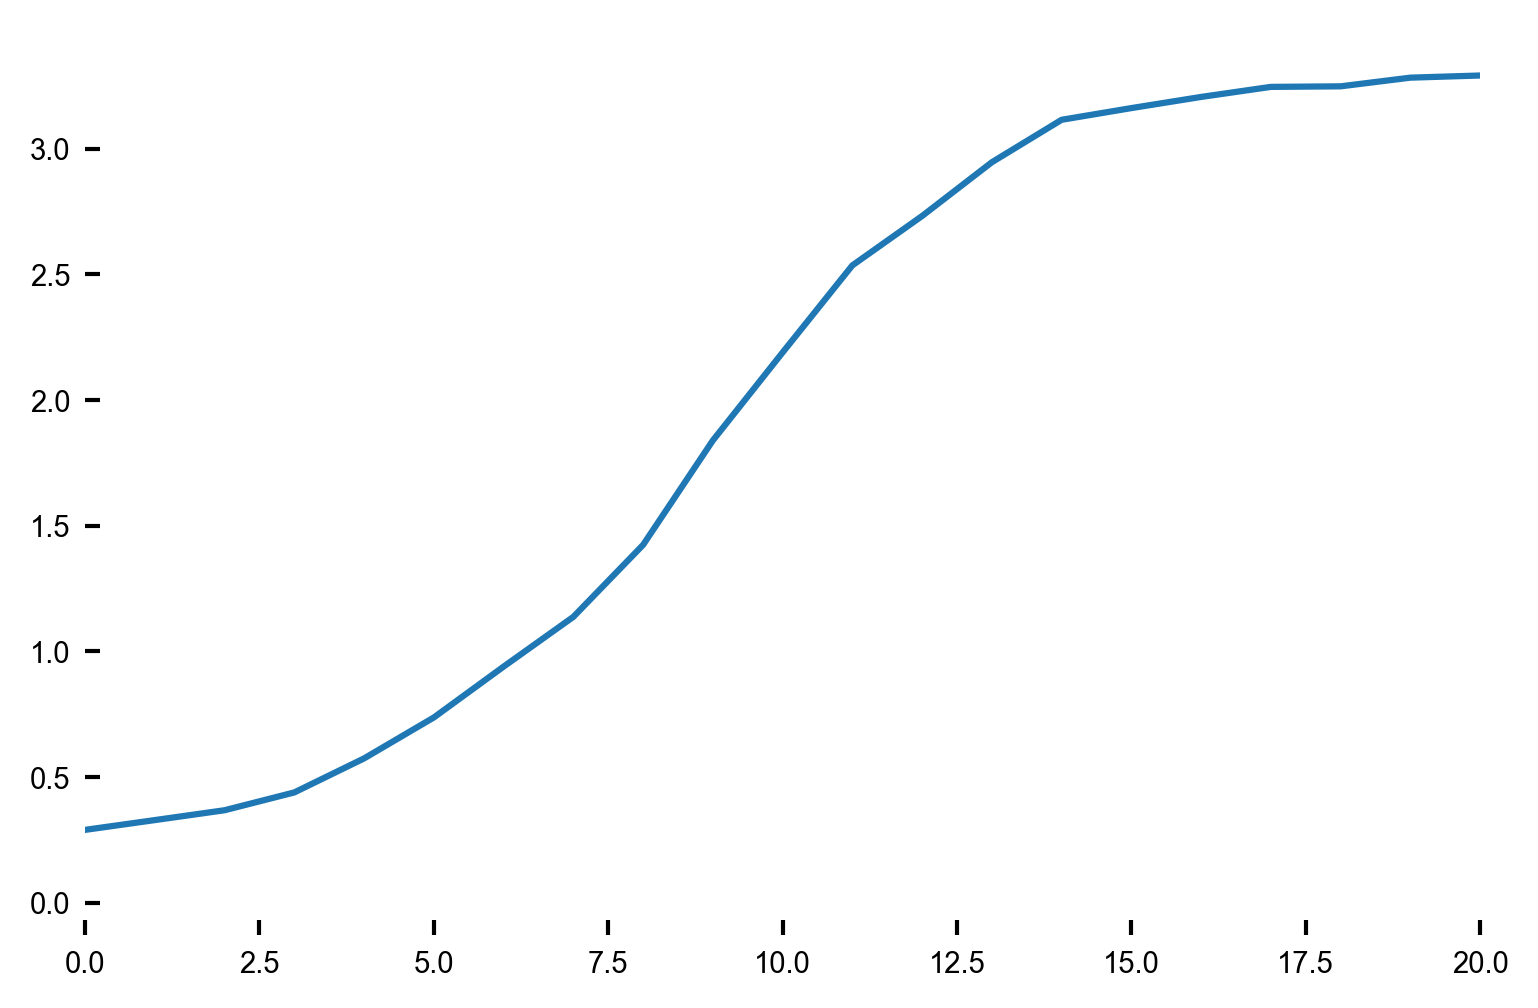

In [52]:
from PIL import Image
# Load myosin embryo 
eId = 202007081130
#eId = 202007091200
#eId = 202007011145
loaddir = f'../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/{eId}'

morph = pd.read_csv(f'{loaddir}/../morphodynamic_offsets.csv', index_col='embryoID')

raw = Image.open(f'{loaddir}/MAX_Cyl1_2_000000_c1_rot_scaled_view1.tif')
proc = np.load(f'{loaddir}/tensor2D.npy')
time = np.arange(proc.shape[0]).astype(float)
time -= morph.loc[eId, 'offset']

vel = np.load(f'{loaddir}/velocity2D.npy')
plt.plot(time, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)))
plt.xlim([0, 20])

3 (4, 236, 200) (2050, 1738)
0 45600 15003.46879676668 1718.7150511409507
33 (4, 236, 200) (2050, 1738)
0 54539 12949.982628757472 2511.1825549815785


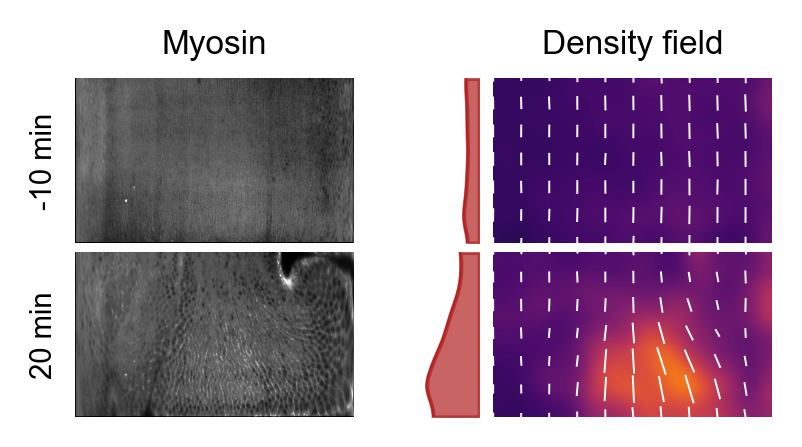

In [53]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from utils.plot_utils import color_2D, plot_tensor2D
from scipy.ndimage import gaussian_filter

plt.style.use('Figure2/Figure2.mplstyle')
plt.rcParams['axes.linewidth'] = 0.0

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()
    

color='firebrick'
t = [-10, 20]

fig, ax = plt.subplots(2, 2, figsize=(3, 1.5))
extent = [0, 452, 0, 533]

tmask = np.logical_and(time > -15, time < 30)
sqh_norm = np.linalg.norm(proc[tmask], axis=(1, 2))
vmin = 0
vmax = 10*np.std(sqh_norm)

cuts = []
for i, tt in enumerate(t):
    idx = np.argmin(np.abs(time - tt))
    proc_t = proc[idx].reshape([-1, 236, 200])
    raw.seek(idx)
    raw_t = np.asarray(raw)
    
    print(idx, proc_t.shape, raw_t.shape)
    print(raw_t.min(), raw_t.max(), raw_t.mean(), raw_t.std())
    color_2D(ax[i, 0], raw_t, 
             vmin=np.mean(raw_t) - 3 * np.std(raw_t), vmax=np.mean(raw_t) + 10 * raw_t.std(),
             extent=extent, cmap='Greys_r')
    
    plot_tensor2D(ax[i, 1], proc_t, extent=extent, vmin=vmin, vmax=vmax)
    cuts.append(get_DV_cut(proc_t, 100, 180))
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
cuts = np.stack(cuts)
for i in range(2):
    plot_cut(ax[i, 1], cuts[i], 0.2*cuts.max(), cuts.max(), color=color)
    
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('Density field')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

#plt.savefig('Figure2/myosin_replot.svg')

# Figure 2 - A search for sparsity

## Myosin

In [58]:
from utils.dataset import *
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

transform = Reshape2DField()
pmg_cf_mask = np.load('../Public/Masks/pmg_cf_mask.npy')

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 
                           'Sqh-GFP', 
                           'tensor2D', 
                           transform=transform)

100%|██████████| 1/1 [00:00<00:00, 414.62it/s]


Found SVDPipeline for this dataset!


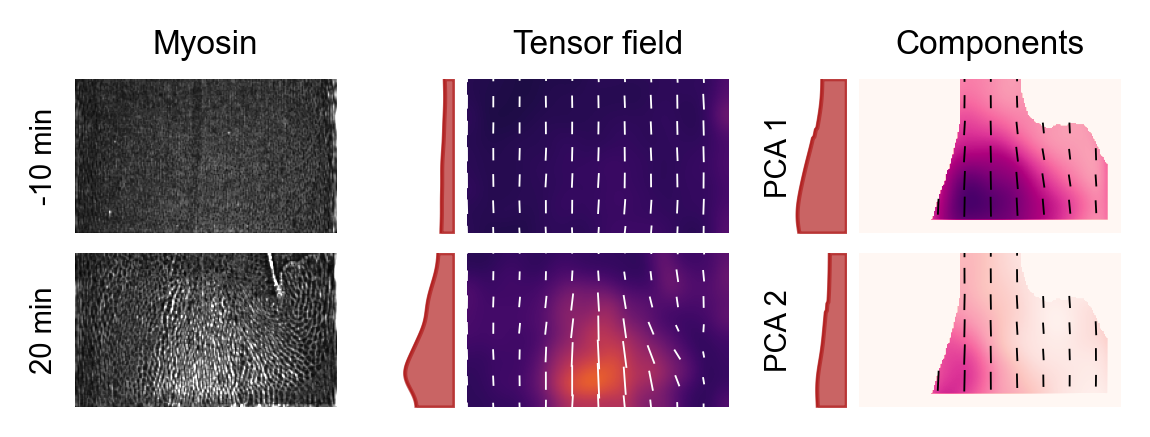

In [165]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from utils.decomposition.decomposition_utils import get_decomposition_results
from utils.plot_utils import color_2D, plot_tensor2D

plt.style.use('Figure2/Figure2.mplstyle')
plt.rcParams['axes.linewidth'] = 0.0

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()

model, df = get_decomposition_results(
    sqh_dataset, 
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

eId = 202007011145
df = df[df.embryoID == eId]
eIdx = df.eIdx.values
sqh = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'tensor2D.npy'),
    mmap_mode='r')[eIdx]
cyt = np.load(
    os.path.join(sqh_dataset.path, str(eId), 'cyt2D.npy'),
    mmap_mode='r')[eIdx]
sqh = sqh.reshape([sqh.shape[0], -1, *sqh.shape[-2:]])
t = df.time.values

    
tmask = np.logical_and(t >= -10, t <= 20)
sqh_norm = np.linalg.norm(sqh[tmask], axis=(1, 2))
vmin = 0
vmax = np.std(sqh_norm)
smin = np.min(cyt[tmask])
smax = smin + 7 * np.std(cyt[tmask])

sqh = interp1d(t, sqh, axis=0)
cyt = interp1d(t, cyt, axis=0)

skip = 20

fig, ax = plt.subplots(2, 3, figsize=(4.5, 1.5))

#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='RdPu'
color='firebrick'

z = np.eye(model['svd'].n_components)
z[0, 0] = 1
z[1, 1] = 1

mask = model['masker'].mask_
z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., mask])
zmax = np.max(znorm[..., mask])
lp=12

t = [-10, 20]

pca_cuts, sqh_cuts = [], []
for i in range(2):
    cyt_t = cyt(t[i])
    color_2D(ax[i, 0], cyt_t, vmin=smin, vmax=smax, cmap='Greys_r')
    
    sqh_t = sqh(t[i])
    plot_tensor2D(ax[i, 1], sqh_t, 
                  vmin=vmin, vmax=vmax)
    sqh_cuts.append(get_DV_cut(sqh_t, 100, 180))
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
    plot_tensor2D(ax[i, 2], z[i], cmap=cmap, 
                  linecolor='black',
                  vmin=zmin, vmax=zmax)
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 20, 60))
    ax[i, 2].set_ylabel(f'PCA {i+1}', labelpad=16)
    
pca_cuts = np.stack(pca_cuts)
sqh_cuts = np.stack(sqh_cuts)
for i in range(2):
    plot_cut(ax[i, 1], sqh_cuts[i], 0.2*sqh_cuts.max(), sqh_cuts.max(), color=color)
    plot_cut(ax[i, 2], pca_cuts[i], 0.2*pca_cuts.max(), pca_cuts.max(), color=color)
    
ax[0, 0].set_title('Myosin')
ax[0, 1].set_title('Tensor field')
ax[0, 2].set_title('Components')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

plt.savefig('Figure2/myosin_components')

Found SVDPipeline for this dataset!


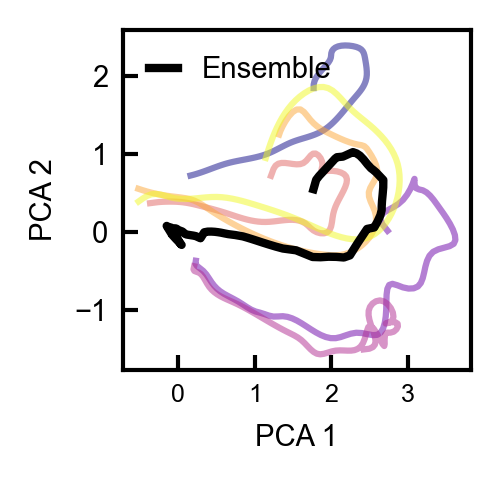

In [146]:
from scipy.interpolate import splprep, splev

plt.style.use('Figure2/Figure2.mplstyle')


model, df = get_decomposition_results(
    sqh_dataset,
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

tmin, tmax = -15, 30
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.02)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

ax.set(xticks=[0, 1, 2, 3], yticks=[-1, 0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

plt.savefig('Figure2/myosin_trajectory.svg', bbox_inches='tight')

## Cadherin

In [148]:
from utils.dataset import *
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

transform = Reshape2DField()
pmg_cf_mask = np.load('../Public/Masks/pmg_cf_mask.npy')
dynamic_mask = np.load('../Public/Masks/Dynamic_PMG_CF_mask.npy', mmap_mode='r')
dynamic_time = np.load('../Public/Masks/Dynamic_PMG_CF_time.npy', mmap_mode='r')
cell_size=7
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'raw2D', #'cyt2D', 
                           transform=Compose([transform, 
                                              Smooth2D(sigma=7)]))

100%|██████████| 6/6 [00:00<00:00, 32.03it/s]


Found SVDPipeline for this dataset!


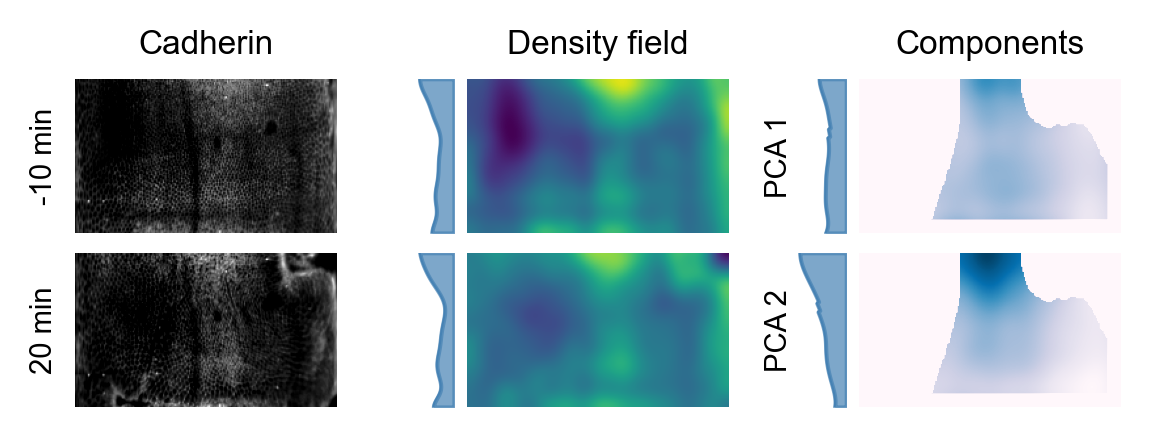

In [184]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d
from utils.decomposition.decomposition_utils import get_decomposition_results
from utils.plot_utils import color_2D, plot_tensor2D

plt.style.use('Figure2/Figure2.mplstyle')
plt.rcParams['axes.linewidth'] = 0.0

def get_DV_cut(z, N0=40, N1=120):
    if len(z.shape) > 2:
        znorm = np.linalg.norm(z, axis=0)
    else:
        znorm = z
    cut = np.sum(znorm[:, N0:N1], axis=1)
    return cut

def plot_cut(ax, cut, vmin, vmax, color):
    L = cut.shape[0] // 2
    y = np.linspace(*ax.get_ylim(), L)
    ax_Y = ax.inset_axes([-0.25, 0, 0.2, 1], sharey=ax)
    
    ax_Y.plot(cut[:L], y, color=color, lw=0.5)
    ax_Y.fill_betweenx(y, 
                       np.ones(L)*vmin, 
                       cut[:L], 
                       color=color, alpha=0.7)
    ax_Y.set_xlim([vmin, vmax*1.05])
    ax_Y.set(xticks=[], yticks=[])
    ax_Y.invert_xaxis()

model, df = get_decomposition_results(
    cad_dataset, 
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

eId = 202001280915
df = df[df.embryoID == eId]
eIdx = df.eIdx.values
cad = np.load(
    os.path.join(cad_dataset.path, str(eId), 'raw2D.npy'),
    mmap_mode='r')[eIdx]
t = df.time.values
    
tmask = np.logical_and(t >= -10, t <= 20)
vmin = np.median(cad[tmask]) - np.std(cad[tmask])
vmax = vmin + 7 * np.std(cad[tmask])

cad = interp1d(t, cad, axis=0)

skip = 20

fig, ax = plt.subplots(2, 3, figsize=(4.5, 1.5))

#Boundary crop
ys, xs = np.where(model['masker'].mask_!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs+1)]

#Color maps
cmap='PuBu'
color='steelblue'

z = np.eye(model['svd'].n_components)
z[0, 0] = 1
z[1, 1] = 1

mask = model['masker'].mask_
z = model.inverse_transform(z)
znorm = np.linalg.norm(z, axis=1)
zmin = np.min(znorm[..., mask])
zmax = np.max(znorm[..., mask])
lp=12

t = [-10, 20]

pca_cuts, cad_cuts = [], []
for i in range(2):
    cad_t = cad(t[i])
    color_2D(ax[i, 0], cad_t, vmin=vmin, vmax=vmax, cmap='Greys_r')
    
    cad_t = Smooth2D(sigma=7)(cad_t[None])
    color_2D(ax[i, 1], cad_t)
    cad_cuts.append(get_DV_cut(cad_t, 100, 180))
    
    ax[i, 0].set_ylabel(f'{t[i]} min')
    
    color_2D(ax[i, 2], z[i], cmap=cmap, 
                  vmin=zmin, vmax=zmax)
    pca_cuts.append(get_DV_cut(z[i][crop_mask], 20, 60))
    ax[i, 2].set_ylabel(f'PCA {i+1}', labelpad=16)
    
pca_cuts = np.stack(pca_cuts)
cad_cuts = np.stack(cad_cuts)
for i in range(2):
    plot_cut(ax[i, 1], cad_cuts[i], 0.6*cad_cuts.max(), cad_cuts.max(), color=color)
    plot_cut(ax[i, 2], pca_cuts[i], 0.6*pca_cuts.max(), pca_cuts.max(), color=color)
    
ax[0, 0].set_title('Cadherin')
ax[0, 1].set_title('Density field')
ax[0, 2].set_title('Components')

fig.subplots_adjust(wspace=0.5, hspace=0.05)

plt.savefig('Figure2/cadherin_components')

Found SVDPipeline for this dataset!


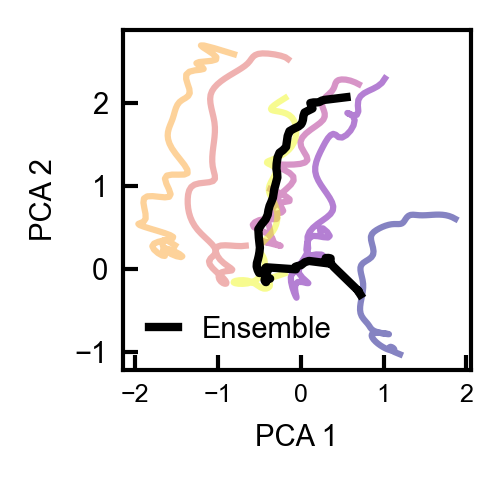

In [196]:
from scipy.interpolate import splprep, splev

plt.style.use('Figure2/Figure2.mplstyle')


model, df = get_decomposition_results(
    cad_dataset,
    model_name='SVDPipeline_PMG_CF', 
    mask=pmg_cf_mask)

tmin, tmax = -15, 30
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))

for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.05)
    x, y, = splev(np.linspace(0, 1, 100), f)
    ax.plot(x, y, c=colors[i], alpha=0.5)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

ax.set(xticks=[-2, -1, 0, 1, 2], yticks=[-1, 0, 1, 2],
       xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='lower left')

plt.savefig('Figure2/cadherin_trajectory.svg', bbox_inches='tight')

## Components vs Accuracy

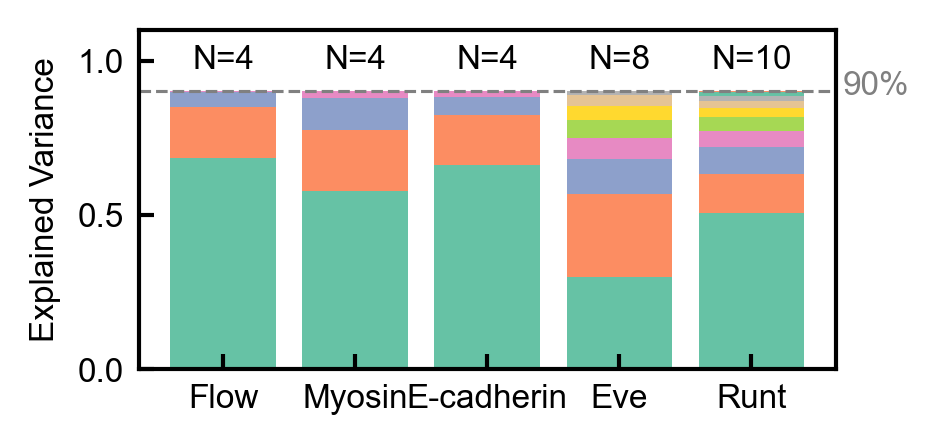

In [56]:
import pickle as pk

plt.style.use('Figure2/Figure2.mplstyle')
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8

models = {
    'Flow': 'WT/ECad-GFP/decomposition_models/velocity_SVDPipeline.pkl',
    'Myosin': 'Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/decomposition_models/tensor_SVDPipeline.pkl',
    'E-cadherin': 'WT/ECad-GFP/decomposition_models/raw_SVDPipeline.pkl',
    'Eve': 'WT/Even_Skipped/decomposition_models/raw_SVDPipeline.pkl',
    'Runt': 'WT/Runt/decomposition_models/raw_SVDPipeline.pkl',
}
df = pd.DataFrame()
for i, key in enumerate(models.keys()):
    models[key] = pk.load(open(os.path.join('../Public', models[key]), 'rb'))
    evr = models[key]['svd'].explained_variance_ratio_
    cum = np.cumsum(evr)
    dfi = pd.DataFrame({'explained_variance': evr, 'total_explained': cum})
    dfi['marker'] = key
    dfi['label'] = i
    df = df.append(dfi)
df = df.reset_index().rename({'index': 'component'}, axis=1)

fig = plt.figure(figsize=(3, 1.5))
ax = fig.gca()

colors = plt.cm.Set2(np.arange(8)) #Set2 has 8 colors

for i in range(df.component.max()):
    dfi = df[(df.component == i) & (df.total_explained <= 0.9)]
    if len(dfi) == 0: continue
    ax.bar(
        dfi.label,
        dfi.explained_variance, 
        bottom=dfi.total_explained-dfi.explained_variance,
        color=colors[i % len(colors)],
    )
ax.axhline(0.9, color='grey', linestyle='--', lw=.75, zorder=1)
ax.text(1.01, 0.88, '90%', transform=ax.transAxes,
        color='grey', va='top', ha='left')
ax.set(yticks = [0, 0.5, 1], ylim=[0, 1.1], ylabel='Explained Variance')
ax.set_ylabel('Explained Variance')
ax.set(
    xticks = df.label.unique(),
    xticklabels = df.marker.unique(),
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

for i in range(df.label.max()+1):
    dfi = df[(df.label == i)].reset_index(drop=True)
    dfn = dfi[dfi.total_explained >= 0.9]
    N = dfn.component.min()
    ax.bar(dfi.label[0], 
           0.9-dfi.total_explained[N-1], 
           bottom=dfi.total_explained[N-1],
           color=colors[N % len(colors)])
    ax.text(i, 0.95, 'N=%d'% (N+1),
            va='bottom', ha='center')

plt.savefig('Figure2/sparsity_summary')

In [222]:
from scipy.stats import sem

df = pd.DataFrame()

#Info pulled from other subplots

df.loc['Myo', '90 percent'] = 4
df.loc['Myo', 'DL Accuracy'] = 0.063
df.loc['Myo', 'DL Errorbar'] = 0.015

df.loc['Cad', '90 percent'] = 4
df.loc['Cad', 'DL Accuracy'] = 0.164
df.loc['Cad', 'DL Errorbar'] = 0.048

df.loc['Rnt', '90 percent'] = 10
df.loc['Rnt', 'DL Accuracy'] = 0.226
df.loc['Rnt', 'DL Errorbar'] = 0.034

df.loc['Eve', '90 percent'] = 8
df.loc['Eve', 'DL Accuracy'] = 0.197
df.loc['Eve', 'DL Errorbar'] = 0.056

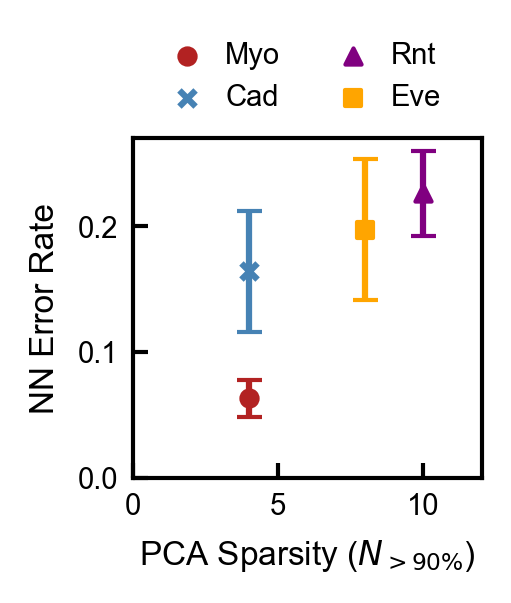

In [256]:
plt.style.use('Figure2/Figure2.mplstyle')
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

def plot_errorbar(label, color, marker=''):
    ax.scatter(
        df.loc[label, '90 percent'], 
        df.loc[label, 'DL Accuracy'], 
        color=color,
        marker=marker,
        s=15,   
        label=label
    )
    ax.errorbar(
        df.loc[label, '90 percent'], 
        df.loc[label, 'DL Accuracy'],
        yerr=df.loc[label, 'DL Errorbar'],
        color=color,
        capsize=3,
    )
    
plot_errorbar('Myo', 'firebrick', 'o')
plot_errorbar('Cad', 'steelblue', 'x')
plot_errorbar('Rnt', 'purple', '^')
plot_errorbar('Eve', 'orange', 's')
ax.set_xlabel('PCA Sparsity ($N_{>90\%}$)')
ax.set_ylabel('NN Error Rate')
ax.set(xlim=[0, 12], xticks=[0, 5, 10])
ax.set(ylim=[0, 0.27], yticks=[0, 0.1, 0.2])
ax.legend(ncol=2, bbox_to_anchor=[0.5, 1], loc='lower center')

plt.savefig('Figure2/sparsity_dl_accuracy')